## Importy

In [53]:
from skimage import io
from skimage.filters import frangi
from matplotlib import pylab as plt
import numpy as np

## Analiza statystyczna

In [54]:
def createConfusionMatrix():
    TP, TN, FP, FN = 1, 1, 1, 1         #TODO
    return TP, TN, FP, FN

def calculateAccuracy(TP, TN, FP, FN):
    return (TP + TN) / (TP + TN + FP + FN)

def calculateSensitivity(TP, TN, FP, FN):
    return TP / (TP + FN)

def calculateSpecificity(TP, TN, FP, FN):
    return TN / (TN + FP)

def calculatePresicion(TP, TN, FP, FN):
    return TP / (TP + FP)

def calculateGMean(TP, TN, FP, FN):
    sensitivity = calculateSensitivity(TP, TN, FP, FN)
    specificity = calculateSpecificity(TP, TN, FP, FN)
    
    return np.sqrt(sensitivity * specificity)

def calculateFMeasure(TP, TN, FP, FN):
    precision = calculatePresicion(TP, TN, FP, FN)
    sensitivity = calculateSensitivity(TP, TN, FP, FN)
    
    return (2 * precision * sensitivity) / (precision + sensitivity)

def displayStatisticalAnalysis():
    TP, TN, FP, FN = createConfusionMatrix()
    
    print("Accuracy:    ", calculateAccuracy(TP, TN, FP, FN))
    print("Sensitivity: ", calculateSensitivity(TP, TN, FP, FN))
    print("Specificity: ", calculateSpecificity(TP, TN, FP, FN))
    print("G-Mean:      ", calculateGMean(TP, TN, FP, FN))
    print("F-Measure:   ", calculateFMeasure(TP, TN, FP, FN))

## Przetwarzanie obrazu

Accuracy:     0.5
Sensitivity:  0.5
Specificity:  0.5
G-Mean:       0.5
F-Measure:    0.5


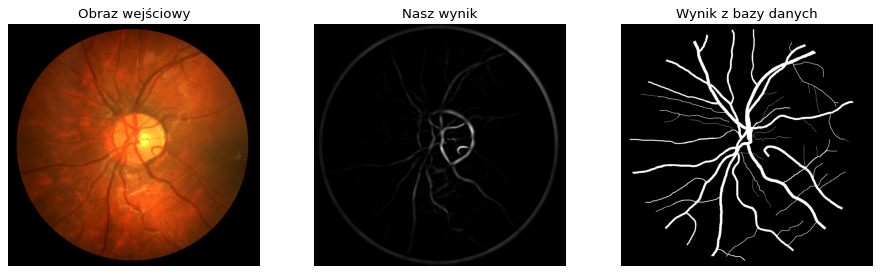

In [57]:
def applyFrangiFilter(processedImage):
    return frangi(processedImage)

def filterImage(processedImage):   
    processedImage = applyFrangiFilter(processedImage)
    
    return processedImage

def displayImages(inputImage, processedImage, result):
    fig = plt.figure(figsize=(14, 4), dpi=80)   
    
    ax = fig.add_subplot(131)
    ax.set_title('Obraz wejściowy')
    ax.imshow(inputImage, cmap = 'gray')
    ax.axis('off')
    
    ax = fig.add_subplot(132)
    ax.set_title('Nasz wynik')
    ax.imshow(processedImage, cmap = 'gray')
    ax.axis('off')
    
    ax = fig.add_subplot(133)
    ax.set_title('Wynik z bazy danych')
    ax.imshow(result, cmap = 'gray') 
    ax.axis('off')
    
def main():
    images = ['Image_01L.jpg', 'Image_01R.jpg']
    results = ['Image_01L_1stHO.png', 'Image_01L_2ndHO.png', 'Image_01R_1stHO.png', 'Image_01R_2ndHO.png',]

    inputImage = io.imread('CHASEDB1/' + images[0])
    processedImage = io.imread('CHASEDB1/' + images[0], as_gray = True)
    result = io.imread('CHASEDB1/' + results[0], as_gray = True)

    processedImage = filterImage(processedImage)
    displayStatisticalAnalysis()
    displayImages(inputImage, processedImage, result)

if __name__ == '__main__':
    main()